In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("user_label_0821.csv")
data.head()

,customer_id,order_cnt,check_cnt,writeoff_cnt,accu_gmv,Ist_ord_dt_diff,Ist_check_dt_diff,Ist_wo_dt_diff
0,4,4,0,8,0.08,91.0,NaN,84.0
1,11,6,0,1,311.06,117.0,NaN,118.0
2,5,105,1,3,3011473.49,78.0,68.0,93.0
3,1,17,1,0,1468.08,96.0,76.0,NaN
4,19,22,0,0,4250.00,82.0,NaN,NaN


## 1. 间隔天数为空填充为9999

In [3]:
data1 = data.fillna(9999)
data1['customer_id'] = data1['customer_id'].astype(str)
data1['customer_id']

0        4
1       11
2        5
3        1
4       19
      ... 
247    457
248    471
249    466
250    456
251    125
Name: customer_id, Length: 252, dtype: object

## 2. 各标签的用户分布

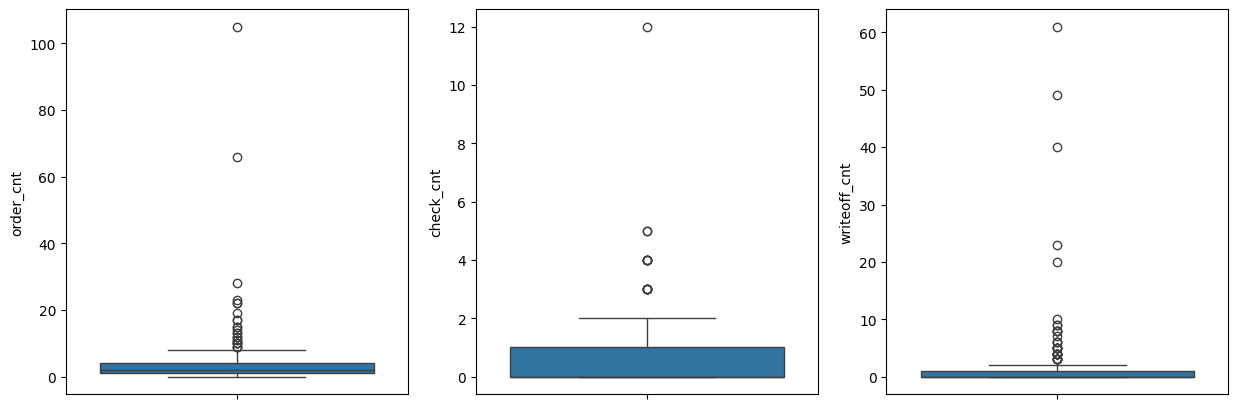

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data1['order_cnt'], ax=axes[0])
sns.boxplot(data1['check_cnt'], ax=axes[1])
sns.boxplot(data1['writeoff_cnt'], ax=axes[2])
plt.show()

In [5]:
data1.head()

,customer_id,order_cnt,check_cnt,writeoff_cnt,accu_gmv,Ist_ord_dt_diff,Ist_check_dt_diff,Ist_wo_dt_diff
0,4,4,0,8,0.08,91.0,9999.0,84.0
1,11,6,0,1,311.06,117.0,9999.0,118.0
2,5,105,1,3,3011473.49,78.0,68.0,93.0
3,1,17,1,0,1468.08,96.0,76.0,9999.0
4,19,22,0,0,4250.00,82.0,9999.0,9999.0


In [6]:
# 对累计gmv分组
group1= [0,199,5000,10000,30000,50000,100000,10000000]
label = ['0-199','199-5000','5000-1w','1w-3w','3w-5w','5w-10w','10w-1000w']
data1['accu_gmv_group']=pd.cut(data1['accu_gmv'],group1,labels=label)

In [7]:
# 对最后一次XX距今天数分组
group2= [0,7,14,30,60,90,120,365]
label2 = ['0-7','7-14','14-30','30-60','60-90','90-120','120=365']
data1['Ist_ord_dt_diff_group']=pd.cut(data1['Ist_ord_dt_diff'],group2,labels=label2)
data1['Ist_check_dt_diff_group']=pd.cut(data1['Ist_check_dt_diff'],group2,labels=label2)
data1['Ist_wo_dt_diff_group']=pd.cut(data1['Ist_wo_dt_diff'],group2,labels=label2)

<Axes: xlabel='Ist_wo_dt_diff_group', ylabel='count'>

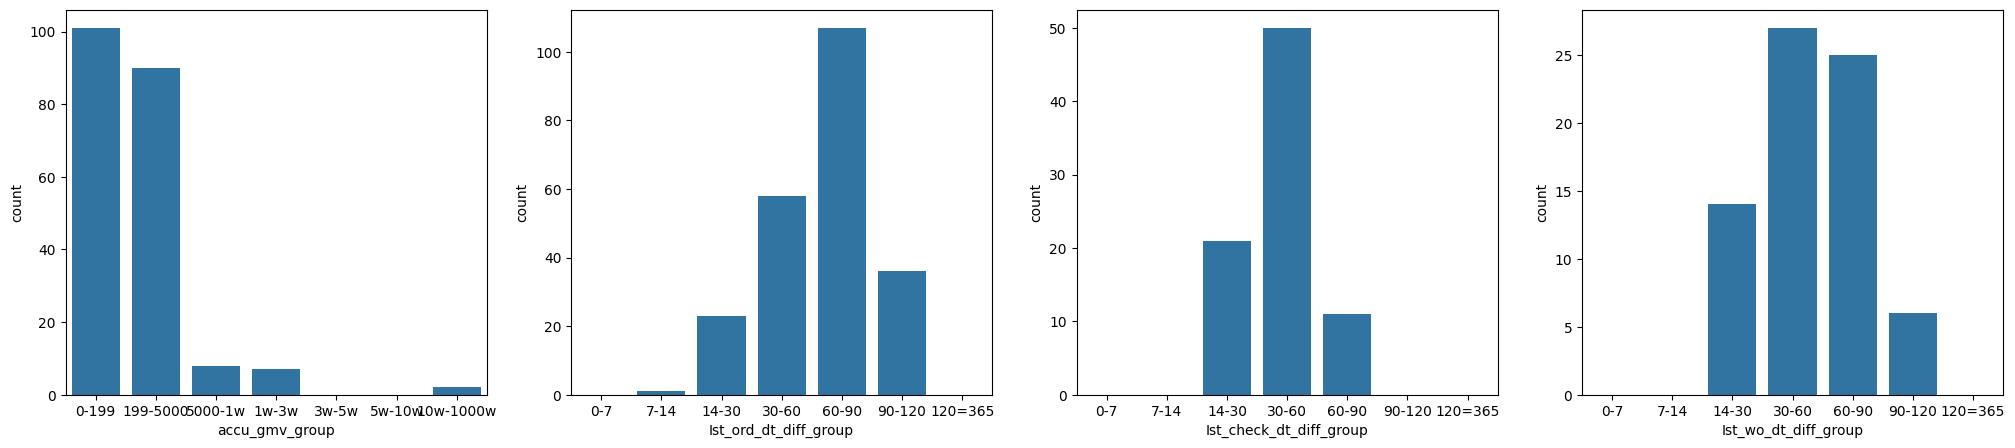

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
sns.countplot(data1,x='accu_gmv_group', ax= axes[0])
sns.countplot(data1,x='Ist_ord_dt_diff_group', ax= axes[1])
sns.countplot(data1,x='Ist_check_dt_diff_group', ax= axes[2])
sns.countplot(data1,x='Ist_wo_dt_diff_group', ax= axes[3])

In [9]:
data1.describe()

,order_cnt,check_cnt,writeoff_cnt,accu_gmv,Ist_ord_dt_diff,Ist_check_dt_diff,Ist_wo_dt_diff
count,252.000000,252.000000,252.000000,2.520000e+02,252.000000,252.000000,252.000000
mean,3.944444,0.559524,1.603175,1.703376e+04,1131.158730,6759.373016,7158.896825
std,8.611866,1.191114,6.011383,1.996336e+05,3078.111945,4673.869616,4499.550995
min,0.000000,0.000000,0.000000,0.000000e+00,13.000000,19.000000,20.000000
25%,1.000000,0.000000,0.000000,3.750000e+00,48.750000,55.000000,90.000000
50%,2.000000,0.000000,0.000000,1.000000e+02,77.500000,9999.000000,9999.000000
75%,4.000000,1.000000,1.000000,6.015000e+02,90.250000,9999.000000,9999.000000
max,105.000000,12.000000,61.000000,3.011473e+06,9999.000000,9999.000000,9999.000000


## 方法一，手工分类，对标平均值

In [10]:
data_for_model = data1.loc[:,['customer_id','accu_gmv','order_cnt','Ist_ord_dt_diff']]
data_for_model.rename(columns={'Ist_ord_dt_diff':'R','order_cnt':'F','accu_gmv':'M'},inplace=True)

In [11]:
data_for_model

,customer_id,M,F,R
0,4,0.08,4,91.0
1,11,311.06,6,117.0
2,5,3011473.49,105,78.0
3,1,1468.08,17,96.0
4,19,4250.00,22,82.0
...,...,...,...,...
247,457,0.00,0,9999.0
248,471,0.00,0,9999.0
249,466,0.00,0,9999.0
250,456,0.00,0,9999.0


In [12]:
#判断R列是否大于等于R列的平均值，将符合条件R_S列的值赋值为1,小于平均值赋值为2
data_for_model['R_S']=np.where(data_for_model['R']>=data_for_model['R'].mean(),1,2)
#同R_S赋值方法，对F_S、M_S进行赋值，但与R相反，F、M均为越大越好
data_for_model['F_S']=np.where(data_for_model['F']>=data_for_model['F'].mean(),2,1)
data_for_model['M_S']=np.where(data_for_model['M']>=data_for_model['M'].mean(),2,1)
data_for_model

,customer_id,M,F,R,R_S,F_S,M_S
0,4,0.08,4,91.0,2,2,1
1,11,311.06,6,117.0,2,2,1
2,5,3011473.49,105,78.0,2,2,2
3,1,1468.08,17,96.0,2,2,1
4,19,4250.00,22,82.0,2,2,1
...,...,...,...,...,...,...,...
247,457,0.00,0,9999.0,1,1,1
248,471,0.00,0,9999.0,1,1,1
249,466,0.00,0,9999.0,1,1,1
250,456,0.00,0,9999.0,1,1,1


In [13]:
#计算RFM综合分值
data_for_model['RFM']=data_for_model['R_S'].map(str)+data_for_model['F_S'].map(str)+data_for_model['M_S'].map(str)
data_for_model.head()

,customer_id,M,F,R,R_S,F_S,M_S,RFM
0,4,0.08,4,91.0,2,2,1,221
1,11,311.06,6,117.0,2,2,1,221
2,5,3011473.49,105,78.0,2,2,2,222
3,1,1468.08,17,96.0,2,2,1,221
4,19,4250.00,22,82.0,2,2,1,221


In [14]:
#定义RFM综合分值与客户类型的对应关系表
CustomerType=pd.DataFrame(data={'RFM':['111','112','121','122','211','212','221','222'],'type':['一般挽留客户','重要挽留客户','一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户']},index=None)
CustomerType

,RFM,type
0,111,一般挽留客户
1,112,重要挽留客户
2,121,一般保持客户
3,122,重要保持客户
4,211,一般发展客户
5,212,重要发展客户
6,221,一般价值客户
7,222,重要价值客户


In [15]:
#将data_for_modela与RFM综合分值客户类型的对应关系表合并为一个数据框
data_for_model_final=pd.merge(data_for_model, CustomerType, on='RFM')
with pd.option_context('display.max_rows',None):
    print(data_for_model_final)

    customer_id           M    F       R  R_S  F_S  M_S  RFM    type
0             4        0.08    4    91.0    2    2    1  221  一般价值客户
1            11      311.06    6   117.0    2    2    1  221  一般价值客户
2             1     1468.08   17    96.0    2    2    1  221  一般价值客户
3            19     4250.00   22    82.0    2    2    1  221  一般价值客户
4             6      322.04    9    98.0    2    2    1  221  一般价值客户
5            32       13.00    4   114.0    2    2    1  221  一般价值客户
6            20      500.00    7    91.0    2    2    1  221  一般价值客户
7            47     1695.05   17    98.0    2    2    1  221  一般价值客户
8             7      200.08    8   100.0    2    2    1  221  一般价值客户
9            63      103.04    4    68.0    2    2    1  221  一般价值客户
10           64        9.00    5    96.0    2    2    1  221  一般价值客户
11           66        6.00    6    97.0    2    2    1  221  一般价值客户
12           67        3.00    4    96.0    2    2    1  221  一般价值客户
13           50      325.00    4  

In [16]:
# 设置字体
from matplotlib.font_manager import FontProperties
# 设置中文字体，注意路径可能会根据实际情况有所调整
font_path = r'C:\Windows\fonts\simhei.TTF'  # 这是思源宋体在 Ubuntu 下的路径，Windows 下路径会有所不同
font_prop = FontProperties(fname=font_path)

# 设置全局中文字体
plt.rcParams['font.family'] = font_prop.get_name()
# 设置 Seaborn 样式和字体
sns.set(font=font_prop.get_name())

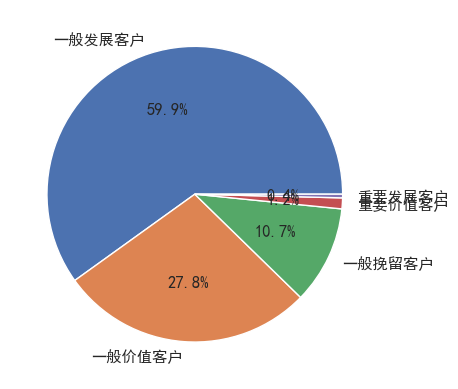

type
一般发展客户    151
一般价值客户     70
一般挽留客户     27
重要价值客户      3
重要发展客户      1
Name: count, dtype: int64


In [17]:
#RMF模型可视化
final = data_for_model_final['type'].value_counts()
plt.pie(final,labels= final.index,autopct='%.1f%%')
plt.show()
print(final)

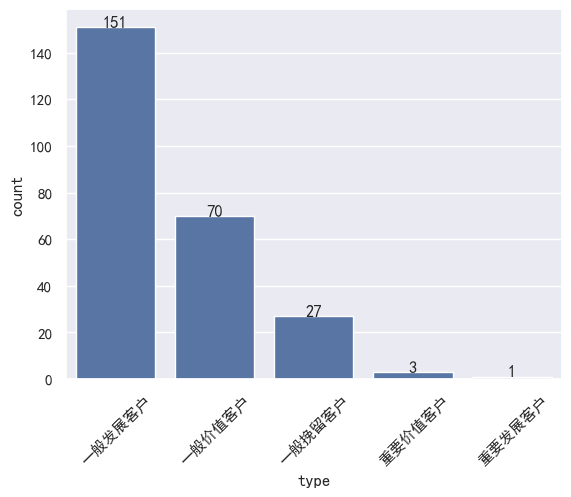

In [18]:
#RMF模型可视化
v = data_for_model_final['type'].value_counts()
plt.xticks(rotation=45)
ax = sns.countplot(x=data_for_model_final['type'],order=v.index)
#在图像上绘制数值
for x,y in enumerate(v):
    text = ax.text(x,y,y)
    #文本数据居中对齐
    text.set_ha('center')

## 方法二，K-Means 聚类

In [19]:
data_for_model_kmeans = data1.loc[:,['customer_id','accu_gmv','order_cnt','Ist_ord_dt_diff']]
data_for_model_kmeans.rename(columns={'Ist_ord_dt_diff':'R','order_cnt':'F','accu_gmv':'M'},inplace=True)
data_for_model_kmeans.head()

,customer_id,M,F,R
0,4,0.08,4,91.0
1,11,311.06,6,117.0
2,5,3011473.49,105,78.0
3,1,1468.08,17,96.0
4,19,4250.00,22,82.0


In [20]:
#由于RFM量纲不同，可能导致聚类结果不好，所以我们先进行数据标准化
from sklearn.preprocessing import StandardScaler
#采用StandardScaler方法对数据规范化：均值为0，方差为1的正态分布,z = (x - μ) / σ
g = StandardScaler()  
stand_data = g.fit_transform(data_for_model_kmeans)
stand_data

array([[-1.71226934e+00, -8.54945025e-02,  6.46388547e-03,
        -3.38593501e-01],
       [-1.66098934e+00, -8.39336485e-02,  2.39163762e-01,
        -3.30129955e-01],
       [-1.70494362e+00,  1.50295295e+01,  1.17578077e+01,
        -3.42825274e-01],
       ...,
       [ 1.67221047e+00, -8.54949040e-02, -4.58935868e-01,
         2.88666848e+00],
       [ 1.59895333e+00, -8.54949040e-02, -4.58935868e-01,
         2.88666848e+00],
       [-8.25857957e-01, -8.54949040e-02, -4.58935868e-01,
         2.88666848e+00]])

In [21]:
data_for_model_kmeans_stand = pd.DataFrame(stand_data,columns=data_for_model_kmeans.columns,index=data_for_model_kmeans.index)
data_for_model_kmeans_stand.head()

,customer_id,M,F,R
0,-1.712269,-0.085495,0.006464,-0.338594
1,-1.660989,-0.083934,0.239164,-0.330130
2,-1.704944,15.029530,11.757808,-0.342825
3,-1.734246,-0.078126,1.519013,-0.336966
4,-1.602384,-0.064164,2.100763,-0.341523


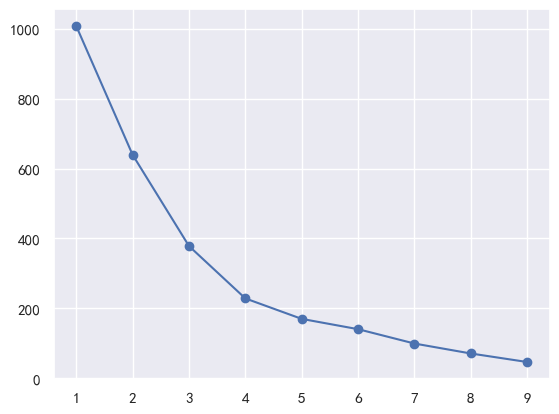

In [22]:
#根据最小的SSE原则确定簇数量，选择最佳的K值，即客户的类别数量
from sklearn.cluster import KMeans
#定义SSE列表，用来存放不同K值下的SSE
SSE = []
#定义候选K值
for i in range(1,10):
    kmeans = KMeans(n_clusters = i,random_state = 12)
    kmeans.fit(data_for_model_kmeans_stand)
    SSE.append(kmeans.inertia_)
#使用手肘法看K值
plt.plot(range(1,10),SSE,marker = 'o')
plt.show()

In [23]:
#使用轮廓系数看K值:轮廓系数是描述簇内外差异的关键指标,越接近1，聚类效果越好
from sklearn.metrics import silhouette_score
kc = KMeans(n_clusters=4,random_state=12)
kc.fit(data_for_model_kmeans_stand)
silhouette_score(stand_data,kc.labels_)

0.46640092814181544

In [24]:
#使用轮廓系数看K值:轮廓系数是描述簇内外差异的关键指标,越接近1，聚类效果越好
from sklearn.metrics import silhouette_score
kc = KMeans(n_clusters=3,random_state=12)
kc.fit(data_for_model_kmeans_stand)
silhouette_score(stand_data,kc.labels_)

0.6272697112054544

In [ ]:
k=3时的轮廓系数为0.63，大于k=4时的轮廓系数0.47，故k=3

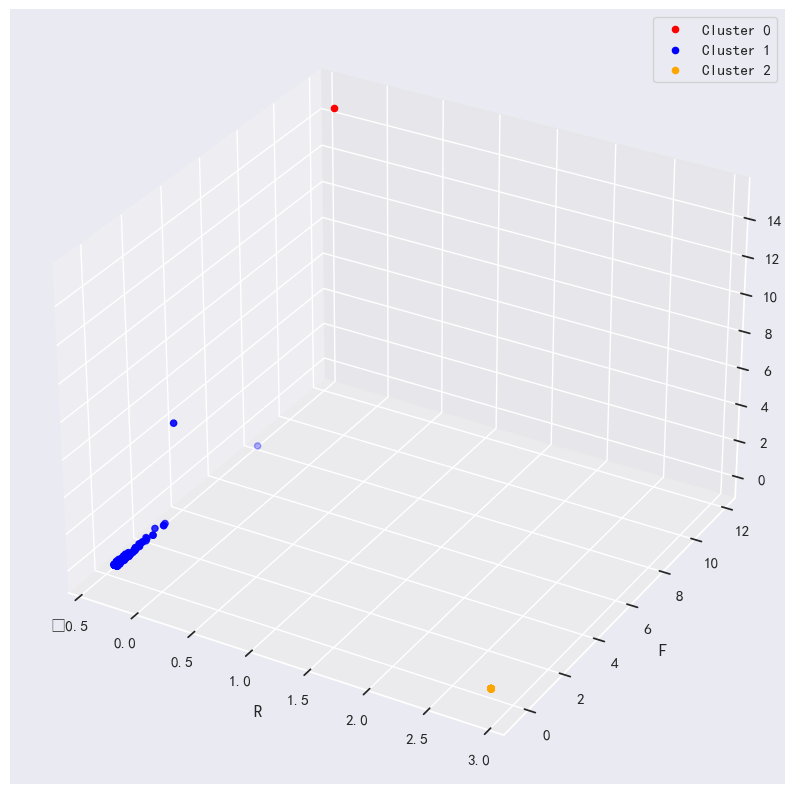

In [83]:
from mpl_toolkits.mplot3d import Axes3D
#执行聚类
kmeans = KMeans(n_clusters=3,random_state=12)
result = kmeans.fit(data_for_model_kmeans_stand)   # 完成拟合，生成结果

# 将聚类标签添加到数据中
data_for_model_kmeans_stand['cluster'] = result.labels_

# 可视化
fig = plt.figure(figsize=(10,12))  ## 设置画布尺寸
ax = fig.add_subplot(111, projection='3d')   ## 画布中写入3维图表
colors = ['red', 'blue', 'orange']  # 设定三个簇的颜色

# 将聚类标签的数据类型转换为整数型
data_for_model_kmeans_stand['cluster'] = data_for_model_kmeans_stand['cluster'].astype('int')

# 根据聚类标签将数据点绘制到3D图表中
for cluster_label in range(3):  # 假设我们选择了3个簇
    cluster_data = data_for_model_kmeans_stand[result.labels_==cluster_label]
    ax.scatter(cluster_data['R'], cluster_data['F'], cluster_data['M'], c=colors[cluster_label], label=f'Cluster{cluster_label}')

#  显示图例
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.legend()   
plt.show()

In [47]:
print(data_for_model_kmeans_stand)
print(result.labels_)

     customer_id          M          F         R  cluster
0      -1.712269  -0.085495   0.006464 -0.338594        1
1      -1.660989  -0.083934   0.239164 -0.330130        1
2      -1.704944  15.029530  11.757808 -0.342825        0
3      -1.734246  -0.078126   1.519013 -0.336966        1
4      -1.602384  -0.064164   2.100763 -0.341523        1
..           ...        ...        ...       ...      ...
247     1.606279  -0.085495  -0.458936  2.886668        2
248     1.708839  -0.085495  -0.458936  2.886668        2
249     1.672210  -0.085495  -0.458936  2.886668        2
250     1.598953  -0.085495  -0.458936  2.886668        2
251    -0.825858  -0.085495  -0.458936  2.886668        2

[252 rows x 5 columns]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

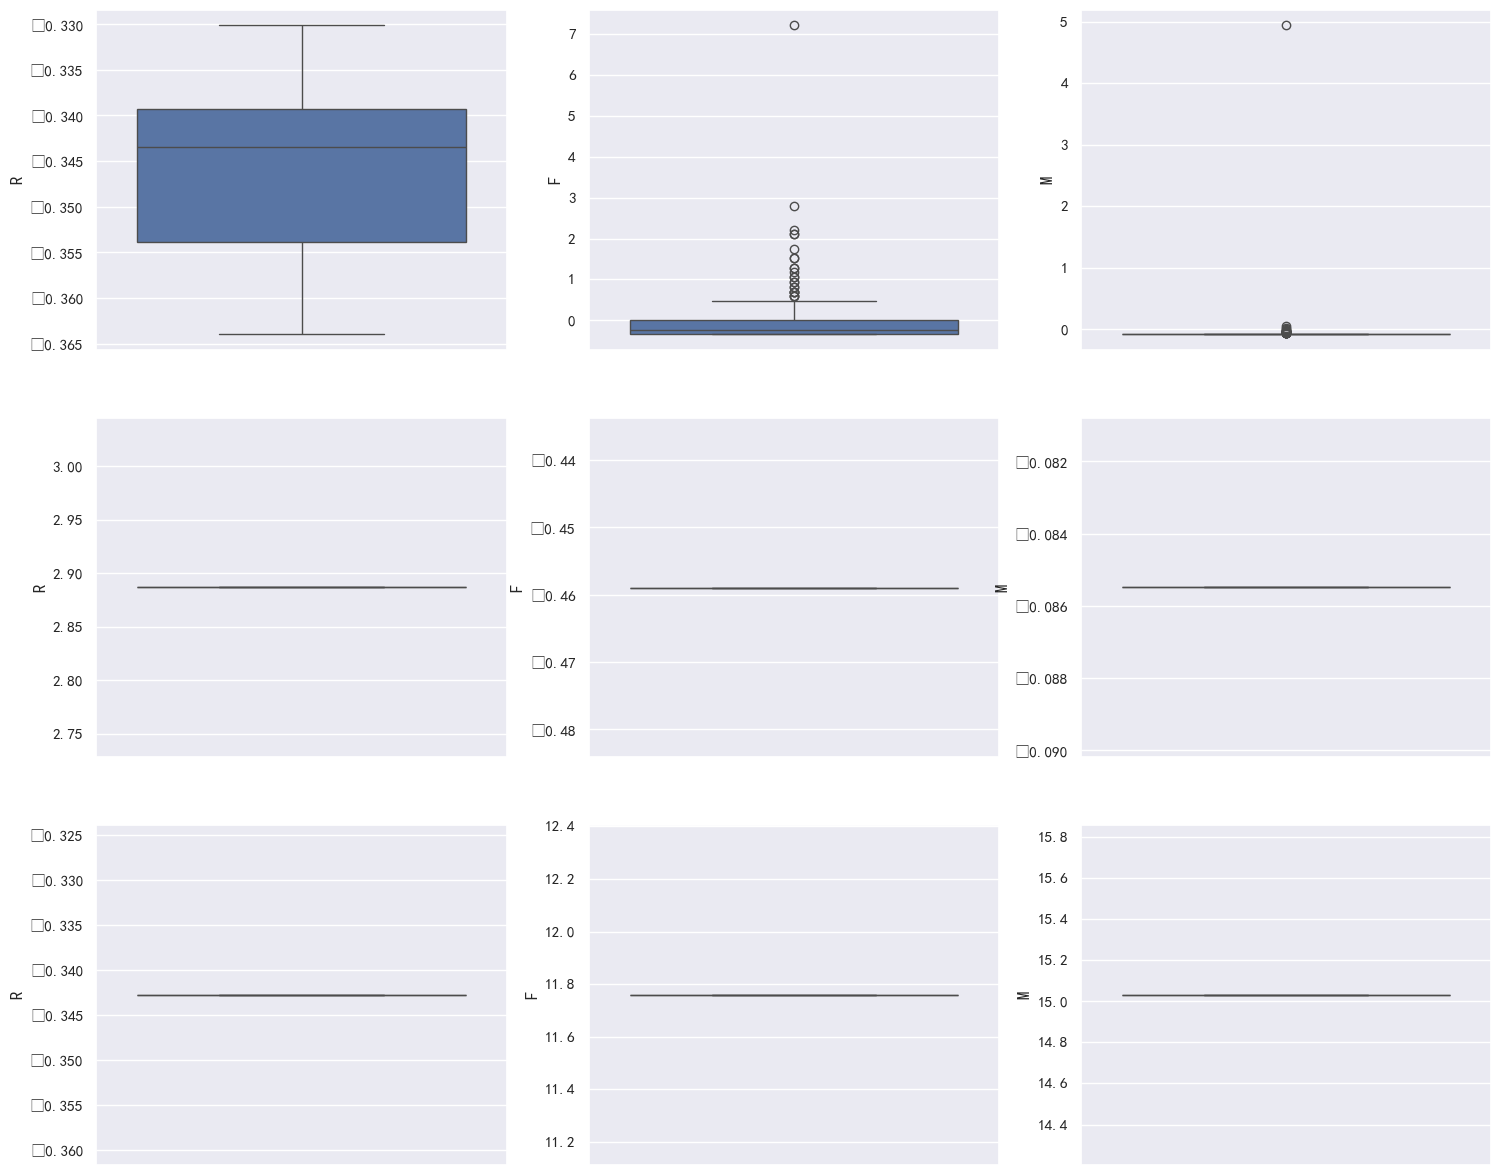

In [29]:
#客户群体分析
fig,ax = plt.subplots(3,3)
fig.set_size_inches(18,15)
for i in range(3):
    #获取第i个客户群的数据
    de = data_for_model_kmeans_stand[kmeans.labels_==i]
    sns.boxplot(y='R',data=de,ax=ax[i][0])
    sns.boxplot(y='F',data=de,ax=ax[i][1])
    sns.boxplot(y='M',data=de,ax=ax[i][2])

In [96]:
#执行聚类
kmeans = KMeans(n_clusters=3,random_state=12)
result = kmeans.fit(data_for_model_kmeans_stand)
#获取每个样本所属的簇，标签的数值对应所属簇的索引
print('标签:',result.labels_)
#获取SSE（簇惯性）
print('SSE:',result.inertia_)
#获取迭代次数
print('迭代次数:',result.n_iter_)
#聚类的分值，分值越大，效果越好,直接取SSE的相反数
print('分值:',result.score(data_for_model_kmeans_stand))

标签: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
SSE: 378.21025902237034
迭代次数: 3
分值: -378.21025902237034


1    224
2     27
0      1
Name: count, dtype: int64


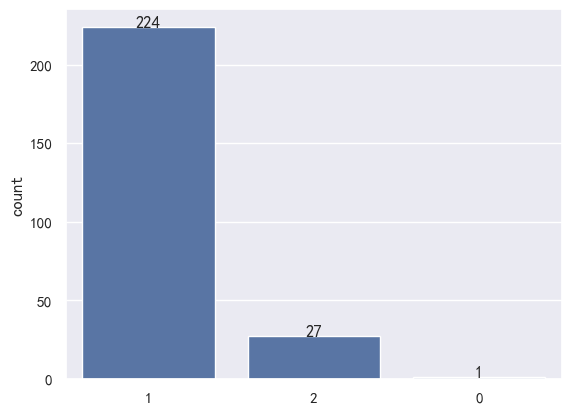

In [93]:
#统计每个类别群体的数量
qt = pd.Series(result.labels_).value_counts()
ax = sns.countplot(x=result.labels_,order=qt.index)
#在图像上绘制数值
for x,y in enumerate(qt):
    text = ax.text(x,y,y) #x,y为填入文本的坐标，y是填充数值
    text.set_ha('center')
print(qt)

In [86]:
# # 创建柱形图
# category_counts = pd.Series(result.labels_).value_counts()
# plt.bar(category_counts.index, category_counts.values)

# # 在柱形图上显示数量
# for i, v in enumerate(category_counts.values):
#     plt.text(i, v, str(v), ha='center', va='bottom')

# # 设置图表标题和标签
# plt.title('Category Counts')
# plt.xlabel('Category')
# plt.ylabel('Count')

# # 显示图表
# plt.show()

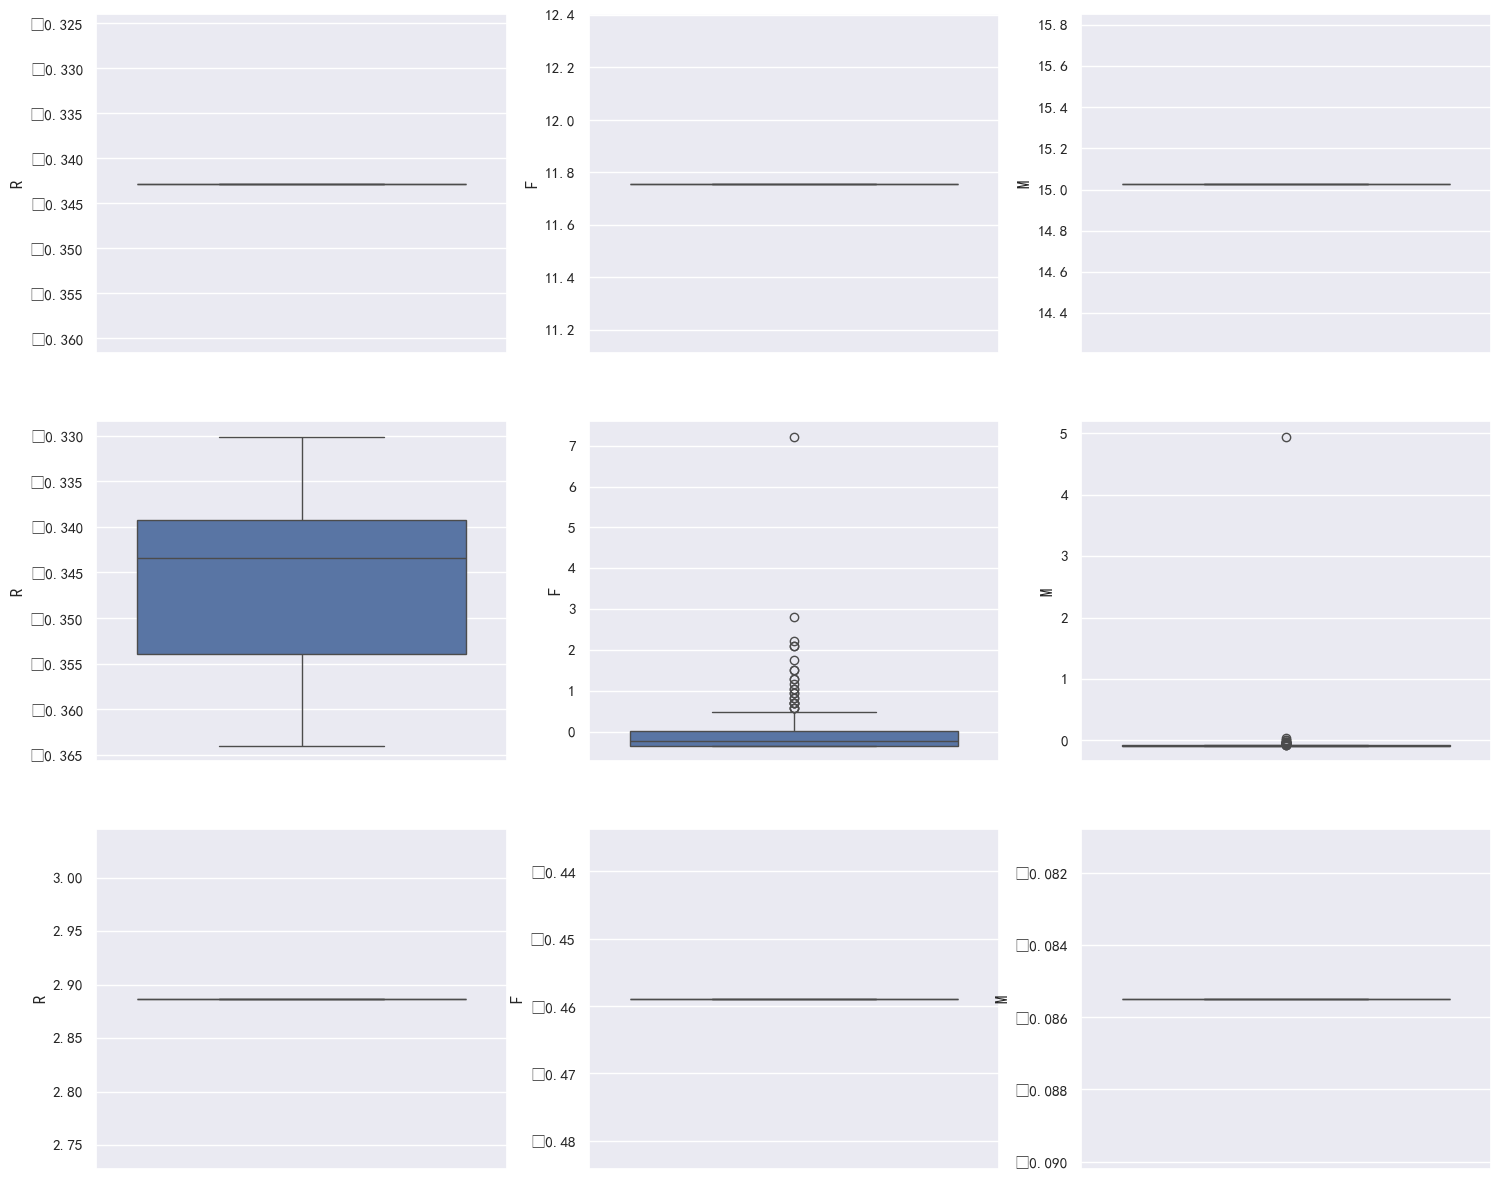

In [110]:
#客户群体分析
fig,ax = plt.subplots(3,3,figsize=(18,15))
for i in range(3):
    #获取第i个客户群的数据
    de = data_for_model_kmeans_stand[data_for_model_kmeans_stand['cluster']== i]
    sns.boxplot(y='R',data=de,ax=ax[i][0])
    sns.boxplot(y='F',data=de,ax=ax[i][1])
    sns.boxplot(y='M',data=de,ax=ax[i][2])